In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() 
from numpy.random import default_rng
rng = default_rng()

# Modèle de Black-Scholes 1d, Put Bermudéen

Soit $(S_t)_{t \in [0,T]}$ un processus de Black-Scholes (Brownien géométrique) de paramètre $r$, $\sigma$ et de valeur initiale fixée $x_0 > 0$, c'est à dire $S_t = x_0 e^{(r-\frac{\sigma^2}{2}) t + \sigma W_t}$ où $(W_t)_{t \in [0,T]}$ est un mouvement Brownien standard.

On considère des dates discrètes fixées $t_n = n \frac{T}{N}$ pour $n = 0, \dots, N$. La valeur de l'actif aux instants $t_n$ forme une chaine de Markov que l'on note $(X_n)_{n = 0,\dots,N}$ c'est à dire 
$$
    \forall n=0, \dots, N, \quad X_n = S_{t_n}
$$
Le put Bermudéen est une option que l'on peut exercer à toute date $t_n$.  Si on exerce en $t_n$ le gain associé (le payoff) est 
$$
    Z_n = \varphi(n, X_n) = e^{-r n \frac{T}{N}} (K - X_n)_+.
$$

On s'intéresse donc au problème d'arrêt optimal à temps discret 
$$
    V_0(x_0) = \sup_{\tau \in \mathcal{T}_0} \mathbf{E}\big[ Z_\tau \big]
    = \sup_{\tau \in \mathcal{T}_0} \mathbf{E}\big[ \varphi(\tau, X_\tau) \big],,
$$
où $\mathcal{T}_0$ est l'ensemble des temps d'arrêts à valeur dans $\{0,\dots,N\}$.

In [2]:
r = 0.1
sigma = 0.25
x0 = 100
K = 110
N, T = 10, 1

In [3]:
def simu_BS1d(size_path, size_sample): 
    h = T/size_path
    brown_acc = np.sqrt(h)*rng.standard_normal(size=(size_path, size_sample))
    sample = np.zeros(shape=(size_path+1, size_sample))
    sample[0] = x0
    for n in range(1, size_path+1):
        sample[n] = sample[n-1] * np.exp((r - 0.5 * sigma**2)*h + sigma*brown_acc[n-1])
    return sample

In [4]:
def payoff_phi(n, x): 
    return np.exp(-r*n*T/N) * np.maximum(K-x, 0)

# Régression sur une base de fonctions 

On considère $m$ fonctions $(e_k)_{1 \le k \le m}$ et la projection sur le sous-espace engendré par les fonctions $(e_k)_{1 \le k \le m}$ c'est à dire la fonction paramètrique 
$$
    \Phi(x; \theta) = \sum_{k=1}^m \theta_k e_k(x) \quad \text{avec $\theta \in \mathbf{R}^m$}.
$$



In [5]:
def base1_ek(x): 
    return np.array([np.ones_like(x),  x, x**2, x**3])

# même base en ajoutant le payoff $(K-x)_+$
def base2_ek(x): 
    return np.array([np.ones_like(x), np.maximum(K-x,0), x, x**2, x**3])

In [6]:
base1_ek(0.2)

array([1.   , 0.2  , 0.04 , 0.008])

In [7]:
base1_ek(np.array([0.2, 0.5]))

array([[1.   , 1.   ],
       [0.2  , 0.5  ],
       [0.04 , 0.25 ],
       [0.008, 0.125]])

In [8]:
def theta_by_regression(payoff, x, ek=base1_ek):
    norm = (ek(x) @ ek(x).T)
    return np.linalg.inv(norm) @ (ek(x) @ payoff)

In [9]:
def function_Phi(x, theta, ek=base1_ek): 
    return np.dot(theta, ek(x))

# Algorithme de Longstaff-Schwartz

On fabrique l'ensemble des scénarios: l'échantillon de $M$ trajectoires $(X^{(j)}_n)_{n=0,\dots,N}$, $1 \le j \le M$ et les payoffs associés $(Z^{(j)}_n)_{n=0,\dots,N}$, $1 \le j \le M$. 

In [10]:
M = int(1e6)
sample_X = simu_BS1d(N, M)
payoffs_Z = np.empty_like(sample_X)
for n in range(0, N+1):
    payoffs_Z[n] = payoff_phi(n, sample_X[n])
    
print("Shape of sample_X: ", sample_X.shape)
print("Shape of payoffs_Z:", payoffs_Z.shape)

Shape of sample_X:  (11, 1000000)
Shape of payoffs_Z: (11, 1000000)


\begin{equation} \tag{$A_{LS}$}
\begin{cases}
    \tau^{(j)}_N = N, & \text{condition terminale} \\
    \tau^{(j)}_{n} = n \mathbf{1}_{Z^{(j)}_n \ge \Phi(X^{(j)}_n; \theta_n)} 
    + \tau^{(j)}_{n+1} \mathbf{1}_{Z^{(j)}_n < \Phi(X^{(j)}_n; \theta_n)}, & 1 \le n \le N-1
\end{cases}
\end{equation}

In [11]:
m = base1_ek(sample_X[0]).shape[0]   # on récupère le nombre de fonctions utilisées
thetas = np.zeros((N, m))            # on va sauver les paramètres "optimaux"

# tau_opt = N * np.ones(M, dtype=int)
payoff_opt = payoffs_Z[N].copy()

for n in reversed(range(1, N)):
    thetas[n] = theta_by_regression(payoff_opt, sample_X[n])
    stop_at_n = payoffs_Z[n] >= function_Phi(sample_X[n], thetas[n]) 
    # tau_opt[stop_at_n] = n 
    payoff_opt[stop_at_n] = payoffs_Z[n, stop_at_n].copy()

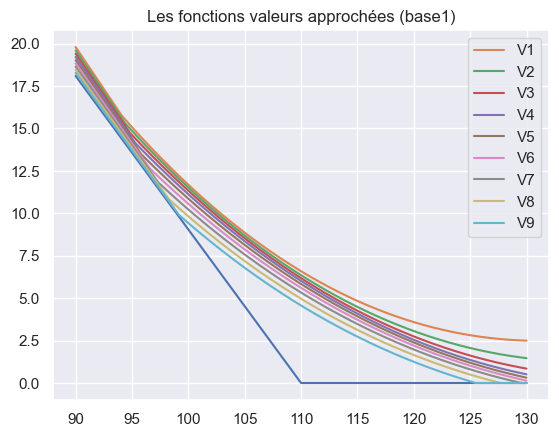

In [12]:
xx = np.linspace(90, 130, 1000)

fig, ax = plt.subplots()
ax.plot(xx, payoff_phi(N, xx))
for n in range(1, N):
    ax.plot(xx, np.maximum(payoff_phi(n, xx), function_Phi(xx, thetas[n], base1_ek)), label=fr"V{n}")
    ax.legend()
    ax.set_title("Les fonctions valeurs approchées (base1)")
plt.show()

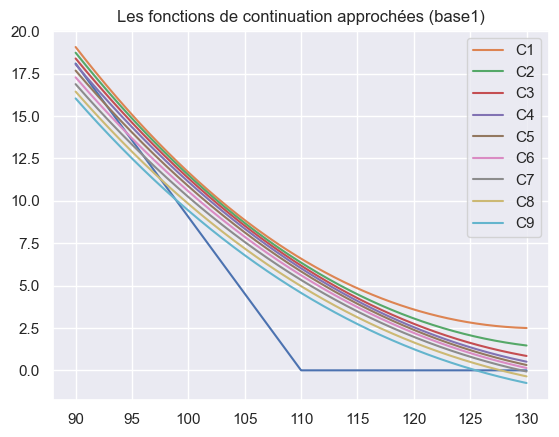

In [13]:
xx = np.linspace(90, 130, 1000)

fig, ax = plt.subplots()
ax.plot(xx, payoff_phi(N, xx))
for n in range(1, N):
    ax.plot(xx, function_Phi(xx, thetas[n]), label=fr"C{n}")
    ax.legend()
    ax.set_title("Les fonctions de continuation approchées (base1)")
plt.show()

In [14]:
def monte_carlo(sample, proba = 0.95):
    mean = np.mean(sample)
    var = np.var(sample, ddof=1)
    alpha = 1 - proba 
    quantile = stats.norm.ppf(1 - alpha/2)  # fonction quantile 
    ci_size = quantile * np.sqrt(var / sample.size)
    result = { 'mean': mean, 'var': var, 
               'lower': mean - ci_size, 
               'upper': mean + ci_size }
    return result

In [15]:
monte_carlo(payoff_opt)

{'mean': 11.895646354957526,
 'var': 85.28126580250873,
 'lower': 11.87754650769969,
 'upper': 11.913746202215362}

# Comparaison des 2 bases

In [16]:
bases = [ 
    { "name": "base1", "ek": base1_ek }, 
    { "name": "base2", "ek": base2_ek },
]

In [17]:
for base in bases:
    m = base["ek"](sample_X[0]).shape[0]    # on récupère le nombre de fonctions utilisées
    thetas = np.zeros((N, m))            # on va sauver les paramètres "optimaux"

    tau_opt = N * np.ones(M, dtype=int)
    payoff_opt = payoffs_Z[N].copy()

    for n in reversed(range(1, N)):
        thetas[n] = theta_by_regression(payoff_opt, sample_X[n], base["ek"])
        stop_at_n = payoffs_Z[n] >= function_Phi(sample_X[n], thetas[n], base["ek"]) 
        tau_opt[stop_at_n] = n 
        payoff_opt[stop_at_n] = payoffs_Z[n, stop_at_n].copy()
    
    base["thetas"] = thetas
    base["payoff_opt"] = payoff_opt

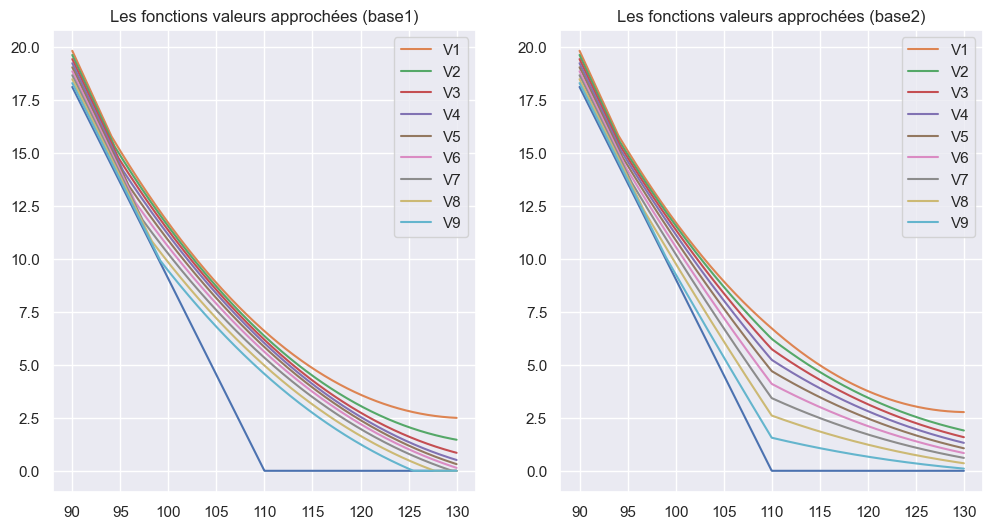

In [18]:
xx = np.linspace(90, 130, 1000)

fig, axs = plt.subplots(ncols=2, figsize=(12,6))
for ax, base in zip(axs, bases): 
    ax.plot(xx, payoff_phi(N, xx))
    for n in range(1, N):
        ax.plot(xx, np.maximum(payoff_phi(n, xx), 
                               function_Phi(xx, base["thetas"][n], base["ek"])), 
                label=fr"V{n}")
        ax.legend()
        name = base["name"]
        ax.set_title(f"Les fonctions valeurs approchées ({name})")
plt.show()

In [19]:
for base in bases: 
    print("Price with", base["name"]) 
    print(monte_carlo(base["payoff_opt"]))

Price with base1
{'mean': 11.895646354957526, 'var': 85.28126580250873, 'lower': 11.87754650769969, 'upper': 11.913746202215362}
Price with base2
{'mean': 11.950977147914713, 'var': 88.44707111583698, 'lower': 11.932544411235032, 'upper': 11.969409884594395}


# Resimulation

...